In [1]:
import os
os.chdir(r"C:\Users\ADMIN\workspace\GitHub\BKAI-Demo-Motorbike-PyQT")

# Constants
ASSETS_DIR = r"Z:\Coded Software\Data Motor\Bench 2024-05-16"

In [2]:
from RealESRGAN import RealESRGAN
import numpy as np
import torch
from PIL import Image
import cv2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
res_model = RealESRGAN(device=device, scale=2)
res_model.load_weights("weight/resolution/RealESRGAN_x2plus.pth")

def upscale_image(image: np.ndarray) -> Image.Image:
    sr_image = res_model.predict(image)
    return sr_image

c:\Users\ADMIN\.conda\envs\motor\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from src.models.detector import YoloDectector
from src.models.classify.main import Models

# Call the detector and classifier
detector = YoloDectector(model_path="weight/yolo/yolov9c.pt", will_classify=False)
resnet_classifier = Models(model="resnet18", num_classes=3)
vit_classifier = Models(model="vit", num_classes=3)
yolo_classifier = Models(model="yolov8")

# Load the weights
resnet_classifier.load_weight("weight/classify/ResNet18.ckpt")
vit_classifier.load_weight("weight/classify/ViT.ckpt")
yolo_classifier.load_weight("weight/classify/YoloV8.pt")

2024-05-18 02:12:42 [    INFO] Weight has been loaded from weight/classify/ResNet18.ckpt (src.models - src\models\classify\main.py:50)
2024-05-18 02:12:43 [    INFO] Weight has been loaded from weight/classify/ViT.ckpt (src.models - src\models\classify\main.py:50)
2024-05-18 02:12:43 [    INFO] Weight has been loaded from weight/classify/YoloV8.pt (src.models - src\models\classify\main.py:53)


In [4]:
# Utils function
import cv2
import uuid
import numpy as np

def draw(
    frame: np.ndarray, 
    bboxes: list, 
    scores: list, 
    class_ids: list
) -> np.ndarray:
    for bbox, score, class_id in zip(bboxes, scores, class_ids):
        x1, y1, x2, y2 = map(int, bbox)
        color = (0, 255, 0)  # Green color for bounding box with class_id 1
        blue = (0, 0, 255)  # Blue color for bounding box with class_id 0
        red = (255, 0, 0)  # Red color for bounding box with class_id 2
        frame = cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
        label = f"Class: {int(class_id)}, Score: {score:.2f}"
        # label = f"Class: {int(class_id)}"
        
        if class_id == 0:
            frame = cv2.putText(
                frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, blue, 4
            )
        elif class_id == 1:
            frame = cv2.putText(
                frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, color, 4
            )
        else:
            frame = cv2.putText(
                frame, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, red, 4
            )

    return frame

def classify(bboxes, img: np.ndarray, classifier: Models) -> list:
        img = Image.fromarray(img)

        class_ids = []
        for bbox in bboxes:
            x1, y1, x2, y2 = map(int, bbox)

            cropped_img = img.crop((x1, y1, x2, y2))
            class_id = classifier.infer(cropped_img)
            cropped_img.save(f".temp/cropped_img_{str(uuid.uuid4())[:4]}_pred_{class_id}.jpg")
            class_ids.append(class_id)

        return class_ids

In [5]:
from PIL import Image
from typing import List, Dict

def infer(img_path: str, detect_conf: float = 0.3, classifiers: List[Models] = [], upscale: bool = False) -> Dict[str, np.ndarray]:
    # Read the image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Upscale the image
    if upscale:
        img = upscale_image(img)
        img = np.array(img)
    
    # Detection phase
    result = detector.detect(frame=img, conf=detect_conf, yolo_class_ids=[3])
    
    # print("result", result)
    
    bboxes, scores = result
    
    # Classify the detected object
    output = {}
    
    for classifier in classifiers:
        name = classifier.name
        class_ids = classify(bboxes, img, classifier)
        
        # Copy the img 
        img_drawed = img.copy()
        
        img_drawed: np.ndarray = draw(img_drawed, bboxes, scores, class_ids)
        output[name] = img_drawed
    
    return output

In [16]:
# Infer the image
import matplotlib.pyplot as plt

def process(img_name: str, parent_dir: str, detect_conf: float = 0.3) -> None:
    before_img_path = f"{parent_dir}/{img_name}.png"
    # after_img_path = f"{parent_dir}/{img_name}_after.png"

    output_before = {
        "Original": cv2.cvtColor(cv2.imread(before_img_path), cv2.COLOR_BGR2RGB),
    }
    # output_after = {
    #     "Original": cv2.cvtColor(cv2.imread(before_img_path), cv2.COLOR_BGR2RGB),
    # }

    output_before.update(infer(before_img_path, detect_conf=detect_conf, classifiers=[resnet_classifier, vit_classifier, yolo_classifier]))
    # output_after.update(infer(before_img_path, upscale=True, detect_conf=detect_conf, classifiers=[resnet_classifier, vit_classifier, yolo_classifier]))
    
    # Plot the image
    fig, ax = plt.subplots(1, 4, figsize=(40, 8))

    for i, (key, value) in enumerate(output_before.items()):
        ax[i].imshow(value)
        ax[i].set_title(f"{key}")
        # ax[0, i].axis("off")
        
    # for i, (key, value) in enumerate(output_after.items()):
    #     ax[1, i].imshow(value)
    #     ax[1, i].set_title(f"{key} - Upscaled")
        # ax[1, i].axis("off")
        
    plt.tight_layout()

    plt.savefig(f"output/output_{img_name}.png")
    print(f"Image saved as output_{img_name}.png")

Image saved as output_img1.png


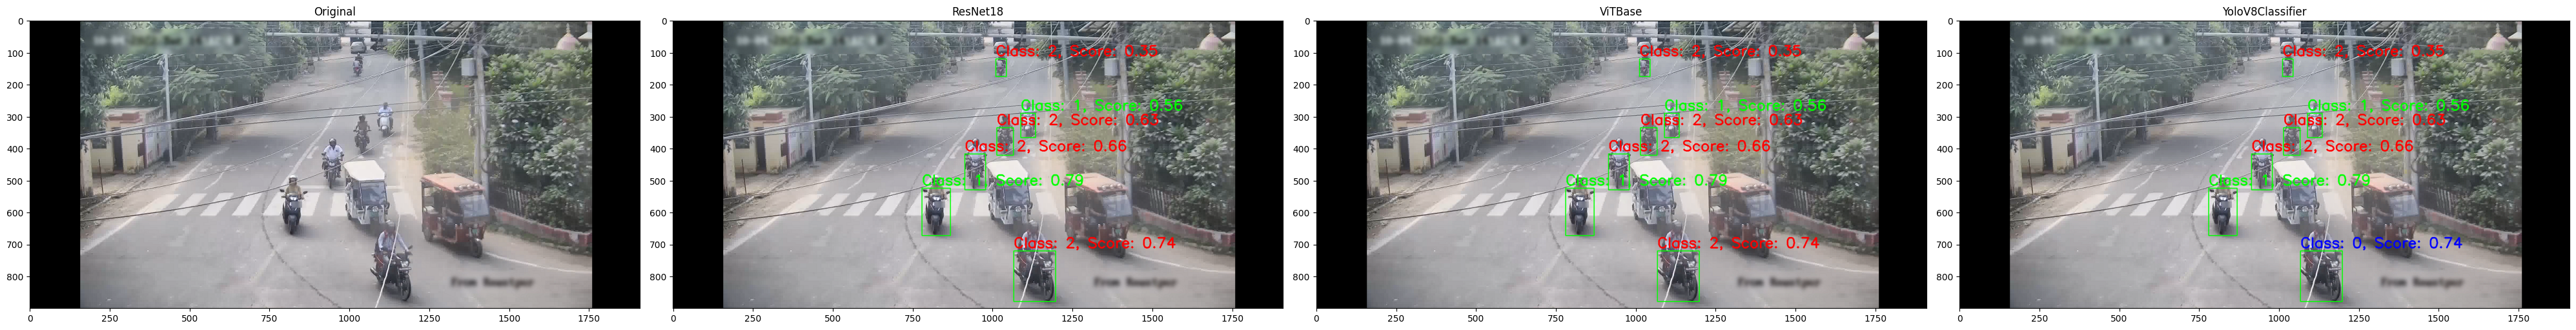

In [17]:
for file_name in os.listdir(ASSETS_DIR):
    if file_name.endswith(".png"):
        process(file_name.split(".")[0], ASSETS_DIR, detect_conf=0.3)
        break